In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset(name='mpsa')
print(f'training N: {len(data_df)}')
data_df.head()

training N: 21929


,training_set,y,dy,x
0,False,-3.751854,0.444200,AAAGCAAAA
1,True,-2.697741,0.369972,AAAGCAAAC
2,True,-2.242947,0.575121,AAAGCAAAG
3,False,-3.067251,0.357014,AAAGCAAAT
4,False,-2.987074,0.472637,AAAGCAACA


In [3]:
#ix = data_df['y'] > -2
#data_df = data_df[ix]

In [4]:
ix = data_df['training_set']
train_df = data_df[ix].reset_index(drop=True)
test_df = data_df[~ix].reset_index(drop=True)
L = len(train_df['x'][0])
L

9

In [5]:
y = train_df['y'].values
from mavenn.src.entropy import entropy_continuous
H_y = entropy_continuous(y, uncertainty=False)
print(f'H_y: {H_y} bits')

H_y: -0.9214138105096705 bits


In [6]:
if False:

    # Set seeed
    mavenn.set_seed(0)

    # Define model
    model = mavenn.Model(L=len(train_df['x'][0]),
                         alphabet='dna',
                         gpmap_type='pairwise',
                         regression_type='GE',
                         ge_noise_model_type='SkewedT',
                         ge_heteroskedasticity_order=2)

    model.set_data(x=train_df['x'],
                   y=train_df['y'])

    # Fit model to data
    history = model.fit(learning_rate=.005,
                        batch_size=200,
                        epochs=1000,
                        early_stopping=True,
                        early_stopping_patience=50,
                        linear_initialization=True,
                        verbose=True)

    model.save('mpsa_ge_pairwise')

In [7]:
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


On test data:
I_intr: 0.808 +- 0.025 bits
I_pred: 0.386 +- 0.013 bits
I_var: 0.301 +- 0.026 bits


Text(0, 0.5, 'bits')

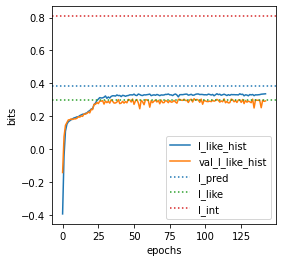

In [8]:
x = test_df['x'].values
y = test_df['y'].values
dy = test_df['dy'].values

print('On test data:')

# Compute intrinsic information
I_intr, dI_intr = mavenn.I_intrinsic(y_values=y, dy_values=dy)
print(f'I_intr: {I_intr:.3f} +- {dI_intr:.3f} bits')

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x, y=y)
print(f'I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

# Compute likelihood information
I_var, dI_var =  model.I_varlihood(x=x, y=y)
print(f'I_var: {I_var:.3f} +- {dI_var:.3f} bits') 

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_hist')
ax.plot(val_I_var_hist, label='val_I_var_hist')
#ax.set_ylim([0,1])
ax.axhline(I_pred, color='C0', linestyle=':', label='I_pred')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var')
ax.axhline(I_intr, color='C3', linestyle=':', label='I_int')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')

In [9]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

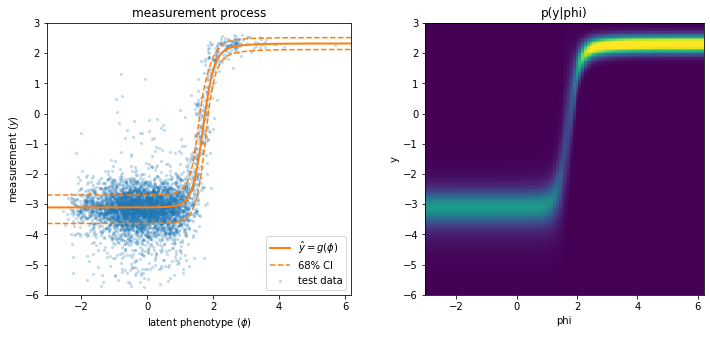

In [24]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 68% CI for each yhat
yqs_grid = model.yhat_to_yq(yhat_grid, q=[0.16, 0.84])

# Create figure
fig, axs = plt.subplots(1, 2, figsize=[12, 5])

# Illustrate measurement process with GE curve
ax = axs[0]
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
y_lim = [-6,3]
ax.set_ylim(y_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Create grids
y_grid = np.linspace(y_lim[0], y_lim[1], 200)
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 100)
yhat_grid = model.phi_to_yhat(phi_grid)

ax = axs[1]
p_y_given_phi = model.p_of_y_given_phi(y_grid, phi_grid, paired=False)
clim = np.quantile(p_y_given_phi.ravel(), q=[0.01, 0.99])
extent = phi_lim + y_lim
im = ax.imshow(p_y_given_phi, 
          extent=extent, 
          interpolation='nearest', 
          origin='lower', 
          vmin=clim[0], 
          vmax=clim[1])
#plt.colorbar(im)
ax.set_title('p(y|phi)')
ax.set_xlabel('phi')
ax.set_ylabel('y')

# Fix up plot
#fig.tight_layout()

plt.show()

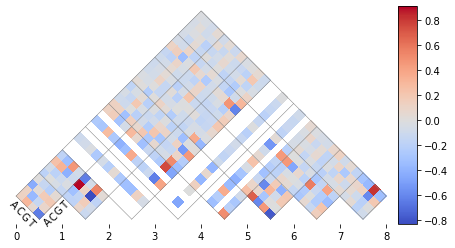

In [15]:
# Plot pairwise parameters
theta_dict = model.get_theta(gauge='uniform')
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(theta_dict['theta_lclc'],
                        alphabet=theta_dict['alphabet'],
                        ax=ax);